# Calculate Exclusion Slopes over Buffer Variations

### In this exercise, you will learn how to calculate exclusion slopes for different criteria. This allows you to better understand which exclusions are critical and which are particularly sensitive to buffer changes in certain ranges. It is an important information for policymaking!

## Import required packages

In [1]:
import glaes as gl
import geokit as gk
import os
import pathlib
from copy import copy

## Define input and output paths and filenames

In [2]:
# NOTE: The results folder exists in your repo under /student_files/results/, but the files created therein will not be pushed back to git

# this is the current working directory ("student_files/exercises")
cwd = pathlib.Path().cwd()
print(f"Current working directory: {cwd}")

# the results folder is in "student_files/results", so go "2 folders up"
results_folder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'results')
# make sure folder exists
assert os.path.isdir(results_folder), f"results folder does not exist: '{results_folder}'"

print(f"Results folder:", results_folder)

Current working directory: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources
Results folder: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results


In [3]:
region_shp = r"region_shapefiles//COUNTRY_gadm_shapes_GID_level_1.shp"

In [4]:
# just like before, we determine our datafolder, here in a one liner
data_basefolder = os.path.join(pathlib.Path().cwd().parent.parent, 'data')
print(data_basefolder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data


## First understand how to fill a table with data iteratively

In [5]:
# import pandas - this should usually be done at the head of the script but is shown here since it is needed for this step
# pandas is the main tool for dataframe handling, the equivalent of tables
import pandas as pd

# with pandas, we can create an empty dataframe which we call 'df'
df = pd.DataFrame()

# the dataframe looks very boring still, it is empty
df

""


In [6]:
# we can set values in the above dataframe like this:
df.loc['first_row_index','first_column_name']='some_value'
# if the row or column indices do not exist, they will be created
df.loc['second_row_index','second_column_name']='also_some_value'
# but we can also set values into existing row/column combinations (we can even overwrite)
df.loc['first_row_index','second_column_name']='existing combination'
# you can see that these row/column combinations where no data has been set are NaN (Not a Number)
df

,first_column_name,second_column_name
first_row_index,some_value,existing combination
second_row_index,NaN,also_some_value


In [7]:
# the for loop will iterate through an iterable of values and the iteration variable (e.g. here: var) will take the value of the respective entry in the iterable
for var in ['a','b',3,'d']:
    print(var) #this will print the value that var takes for each iteration

a
b
3
d


In [8]:
# instead of printing, we can do ANY task here
df = pd.DataFrame()

some_dict={5:20, 10:22, 15:27}
some_otherdict={5:12, 10:19, 15:29}

for var in [5,10,15]:
    df.loc[var, 'some_usecase']=some_dict[var]

# we can do that again for some other usecase
# NOTE that the iterable (here the list [5, 10, 15]) is the same, meaning that no new rows need to be added
for var in [5,10,15]:
    df.loc[var, 'some_other_usecase']=some_otherdict[var]

# we now have a pandas dataframe with some numbers - a small table!
df

,some_usecase,some_other_usecase
5,20.0,12.0
10,22.0,19.0
15,27.0,29.0


<Axes: >

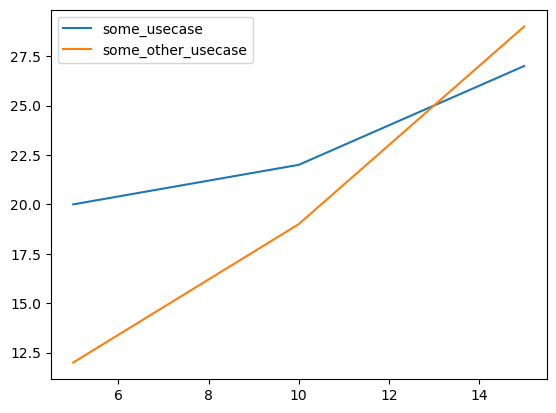

In [9]:
# we can now plot the variations, you see that the index is shown on the x axis and the column values are the y values!
# the legend shows the respective column names
df.plot()

# TASK: Plot the exclusion slope based on at least 10 value pairs, for an exclusion of water surfaces and forests. Use a basic exclusion buffer of 100m for both criteria.

### NOTE: You can use any method, but you may find some of the iteration and plotting approaches helpful that are shown here above. Exclusion calculation was introduced in the earlier exercises. (Please use the study region that we used in the earlier exercises as well)

### NOTE: What information  do you draw from the resulting plot? Make some notes so we can discuss together afterwards!

## Prepare the ec object

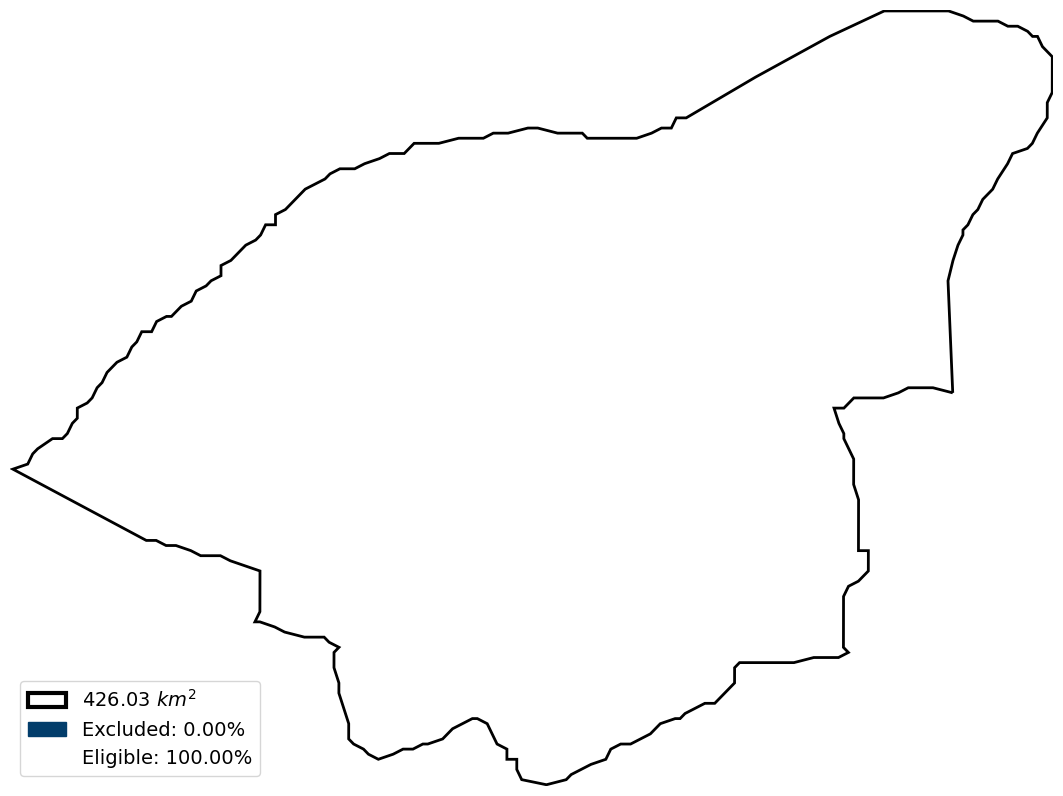

In [10]:
# define main params
region = 'NER.5_1'
resolution = 100

# country code is the first 3 characters of the region code
country = region[:3]

# create an ec object with a metric EPSG, here 3857 centered on lat/lon 0/0 (see: https://epsg.io/3857 )
ec = gl.ExclusionCalculator(
    region=os.path.join(data_basefolder, region_shp.replace("COUNTRY", country)),
    where=f"GID_1 = '{region}'",
    srs=gk.srs.EPSG3857,
    pixelRes=resolution,
)
# draw the resulting ec object
ec.draw()

# create a backup copy
ec_clean = copy(ec)

## Calculate the exclusions

In [11]:
# the input data and exclusion parameters for the required exclusions are known already from earlier subtasks (you can just copy and paste):

exclusions_dict={
    'forests':{
        'exclusion_filepath':r'exclusion_datasets//CGLS//COUNTRY//COUNTRY_warped_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif', #NOTE: sometime you get SyntaxErrors for malformed characters related to backslashes //, this can be resolved by formatting as raw (r) string: r""
        'buffer':100,
        'value':"[111-116],[121-126]", #NOTE: This describes a range of 111 to 116 AND 121 to 126, both INCLUDING the endpoints 
        'resampleAlg':'near',
    },
    'water surfaces':{
        'exclusion_filepath':r'exclusion_datasets//CGLS//COUNTRY//COUNTRY_warped_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif', #NOTE: sometime you get SyntaxErrors for malformed characters related to backslashes //, this can be resolved by formatting as raw (r) string: r""
        'buffer':100,
        'value':"80",  
        'resampleAlg':'near',
    },
    'primary roads':{
        'exclusion_filepath':'exclusion_datasets/OSM/COUNTRY/COUNTRY_gis_osm_roads_free_1.shp',
        'buffer':200,
        'where':"fclass in ('trunk', 'primary', 'primary_link', 'trunk_link', 'motorway')",
    },
    'human settlements':{
        'exclusion_filepath':'exclusion_datasets//WSF2019//COUNTRY//REGION_extract_WSF2019_clipped.tif',
        'buffer':500,
        'value':255, 
        'resampleAlg':'max',
    },
}

In [12]:
# create a dataframe that will hold our exclusion results
results_df = pd.DataFrame()

### now we first exclude forests

In [13]:
# the reference exclusion value is given as 100m
reference_buffer = 100

# it makes sense to vary this value RELATIVELY - we need at least 5 values, I choose 5 values here based on 50% variation steps
relative_variations=[0, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0]

# # we multiply our relative variations with the reference value; for this approach we need to pass the relative variations as a numpy array
# import numpy as np # also this is imported here only for clarity, usually it will be imported at the head of the script
# buffer_variations = np.array(relative_variations) * reference_buffer

# # see what we have : absolute values based on our reference value
# # it is an array, but that does not matter since both lists and arrays are iterables
# buffer_variations

In [14]:
exclusion = 'forests'

# we can now iterate over the buffer_variations
for rel_variation in relative_variations:
    print(f"Now processing buffer value {exclusions_dict[exclusion]['buffer'] * rel_variation}m for exclusion {exclusion}")
    # first reset the ec object to be safe
    ec = copy(ec_clean)
    # the exclude your specific exclusion case
    ec.excludeRasterType(
        source=os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace("COUNTRY", country).replace("REGION", region)),
        value=exclusions_dict[exclusion]['value'],
        buffer=exclusions_dict[exclusion]['buffer'] * rel_variation, # NOTE that the buffer is adapted here by multiplying the reference value by the relative variation
        resampleAlg=exclusions_dict[exclusion]['resampleAlg'],
    )
    # we set the available area percentage as a cell value in our results dataframe
    # using the buffer value as a row and the exclusion feature as column name
    results_df.loc[rel_variation, exclusion]= ec.percentAvailable # we save the eligibility for each case

Now processing buffer value 0m for exclusion forests
Memory useage during calc: 158.3359375 MB
Now processing buffer value 50.0m for exclusion forests
Memory useage during calc: 158.41015625 MB
Now processing buffer value 100.0m for exclusion forests
Memory useage during calc: 158.43359375 MB
Now processing buffer value 150.0m for exclusion forests
Memory useage during calc: 158.44140625 MB
Now processing buffer value 200.0m for exclusion forests
Memory useage during calc: 158.44140625 MB
Now processing buffer value 300.0m for exclusion forests
Memory useage during calc: 158.44140625 MB
Now processing buffer value 500.0m for exclusion forests
Memory useage during calc: 158.44921875 MB


In [15]:
# we can now repeat the exact same thing for the next exclusion
exclusion = 'water surfaces'

for rel_variation in relative_variations:
    print(f"Now processing buffer value {exclusions_dict[exclusion]['buffer'] * rel_variation}m for exclusion {exclusion}")
    # first reset the ec object to be safe
    ec = copy(ec_clean)
    # the exclude your specific exclusion case
    ec.excludeRasterType(
        source=os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace("COUNTRY", country)),
        value=exclusions_dict[exclusion]['value'],
        buffer=exclusions_dict[exclusion]['buffer'] * rel_variation, # NOTE that the buffer is adapted here by multiplying the reference value by the relative variation
        resampleAlg=exclusions_dict[exclusion]['resampleAlg'],
    )
    # save the eligibility to our results dataframe
    results_df.loc[rel_variation, exclusion]= ec.percentAvailable

Now processing buffer value 0m for exclusion water surfaces
Memory useage during calc: 158.33984375 MB
Now processing buffer value 50.0m for exclusion water surfaces
Memory useage during calc: 158.33984375 MB
Now processing buffer value 100.0m for exclusion water surfaces
Memory useage during calc: 158.34375 MB
Now processing buffer value 150.0m for exclusion water surfaces
Memory useage during calc: 158.34765625 MB
Now processing buffer value 200.0m for exclusion water surfaces
Memory useage during calc: 158.34765625 MB
Now processing buffer value 300.0m for exclusion water surfaces
Memory useage during calc: 158.34765625 MB
Now processing buffer value 500.0m for exclusion water surfaces
Memory useage during calc: 158.34765625 MB


In [16]:
# and again for settlements
exclusion = 'human settlements'

for rel_variation in relative_variations:
    print(f"Now processing buffer value {exclusions_dict[exclusion]['buffer'] * rel_variation}m for exclusion {exclusion}")
    # first reset the ec object to be safe
    ec = copy(ec_clean)
    # the exclude your specific exclusion case
    ec.excludeRasterType(
        source=os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace("COUNTRY", country).replace("REGION", region)),
        value=exclusions_dict[exclusion]['value'],
        buffer=exclusions_dict[exclusion]['buffer'] * rel_variation, # NOTE that the buffer is adapted here by multiplying the reference value by the relative variation
        resampleAlg=exclusions_dict[exclusion]['resampleAlg'],
    )
    # save the eligibility to our results dataframe
    results_df.loc[rel_variation, exclusion]= ec.percentAvailable

Now processing buffer value 0m for exclusion human settlements
Memory useage during calc: 179.46875 MB
Now processing buffer value 250.0m for exclusion human settlements
Memory useage during calc: 179.4765625 MB
Now processing buffer value 500.0m for exclusion human settlements
Memory useage during calc: 179.4921875 MB
Now processing buffer value 750.0m for exclusion human settlements
Memory useage during calc: 179.4921875 MB
Now processing buffer value 1000.0m for exclusion human settlements
Memory useage during calc: 179.50390625 MB
Now processing buffer value 1500.0m for exclusion human settlements
Memory useage during calc: 179.51171875 MB
Now processing buffer value 2500.0m for exclusion human settlements
Memory useage during calc: 179.515625 MB


In [17]:
# and once more for primary roads
exclusion = 'primary roads'

for rel_variation in relative_variations:
    print(f"Now processing buffer value {exclusions_dict[exclusion]['buffer'] * rel_variation}m for exclusion {exclusion}")
    # first reset the ec object to be safe
    ec = copy(ec_clean)
    # NOTE: We now have a shapefile as input file, so we need to use excludeVectorType()!
    ec.excludeVectorType(
        source=os.path.join(data_basefolder, exclusions_dict[exclusion]['exclusion_filepath'].replace("COUNTRY", country).replace("REGION", region)),
        where=exclusions_dict[exclusion]['where'],
        buffer=exclusions_dict[exclusion]['buffer'] * rel_variation, # NOTE that the buffer is adapted here by multiplying the reference value by the relative variation
    )
    # save the eligibility to our results dataframe
    results_df.loc[rel_variation, exclusion]= ec.percentAvailable

Now processing buffer value 0m for exclusion primary roads
Now processing buffer value 100.0m for exclusion primary roads
Memory useage during calc: 180.04296875 MB
Now processing buffer value 200.0m for exclusion primary roads
Memory useage during calc: 181.984375 MB
Now processing buffer value 300.0m for exclusion primary roads
Memory useage during calc: 182.07421875 MB
Now processing buffer value 400.0m for exclusion primary roads
Memory useage during calc: 183.0078125 MB
Now processing buffer value 600.0m for exclusion primary roads
Memory useage during calc: 183.0078125 MB
Now processing buffer value 1000.0m for exclusion primary roads
Memory useage during calc: 183.01171875 MB


<Axes: title={'center': 'Exclusion Slope over Buffer Variation for NER.5_1'}, xlabel='Relative variation of base setback distance [-]', ylabel='Eligible percentage of region area [%]'>

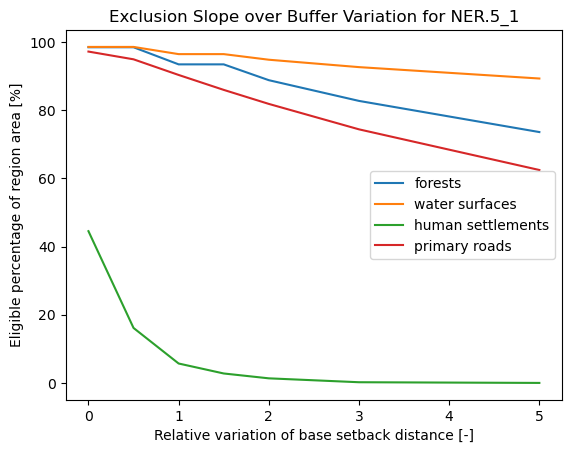

In [18]:
results_df.plot(
    title=f'Exclusion Slope over Buffer Variation for {region}',
    xlabel="Relative variation of base setback distance [-]",
    ylabel="Eligible percentage of region area [%]"
)


In [19]:
# NOTE: You could also have used absolute values instead of relative variations as shown above.
# In that case, however, you need to make sure that all exclusions fit well into the same chart:
# Especially when one reference value is much higher (e.g. airports), you may find this to be difficult.

# QUESTION: What information can you draw from above line plot? 